In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from math import sqrt
import joblib


/Users/shobians./Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [34]:

csv_file = "merged_news_stock_data.csv"
df = pd.read_csv(csv_file, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.dropna(subset=["Date"], inplace=True)
df.reset_index(drop=True, inplace=True)


In [35]:
df

,Date,title,content,link,symbols,tags,sentiment_polarity,sentiment_neg,sentiment_neu,sentiment_pos,Close_Price,High_Price,Low_Price,Open_Price,Volume
0,2016-02-19,Payment Data Systems Announces Apple Pay Suppo...,"SAN ANTONIO, Feb. 19, 2016 (GLOBE NEWSWIRE) ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, PYDS.US, USIO.US","AKIMBO, AKIMBO CARD, APPLE, APPLE PAY, FICENTI...",0.994,0.023,0.869,0.108,21.845985,22.009762,21.791394,21.836887,141496800
1,2017-10-05,New Research: Key Drivers of Growth for Micros...,"NEW YORK, Oct. 05, 2017 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, AMZN.US, INTC.US, MSFT.US, QCOM.US, T...",FUNDAMENTAL MARKETS,0.997,0.008,0.925,0.067,36.384716,36.396424,36.070955,36.101392,85135200
2,2017-11-27,"Factors of Influence in 2018, Key Indicators a...","NEW YORK, Nov. 27, 2017 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, CSCO.US, GD.US, HPE.US, NVDA.US, S.US",FUNDAMENTAL MARKETS,0.997,0.008,0.926,0.065,40.909874,41.142518,40.733629,41.135469,82867200
3,2017-11-30,"BioTelemetry, Inc. Enters Agreement to Provide...","MALVERN, Pa., Nov. 30, 2017 (GLOBE NEWSWIRE)...",https://www.globenewswire.com/news-release/201...,"AAPL.US, BEAT.US","BIOTELEMETRY, INC, NASDAQ:BEAT",0.989,0.021,0.804,0.174,40.383492,40.451638,39.582166,40.049799,166108800
4,2018-01-31,Investor Expectations to Drive Momentum within...,"NEW YORK, Jan. 31, 2018 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"AAPL.US, AVHI.US, FARM.US, GM.US, SGRY.US",FUNDAMENTAL MARKETS,0.995,0.009,0.937,0.054,39.344833,39.582178,39.126292,39.213238,129915600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26576,2024-11-26,What Is the S&P 500 Index?,What Is the S&P 500 Index?,https://www.fool.com/investing/stock-market/in...,"AAPL.US, AMZN.US, GOOG.US, GOOGL.US, META.US, ...",NaN,0.000,0.000,1.000,0.000,234.801834,235.311284,233.073738,233.073738,45986200
26577,2024-11-26,Dow Jones Industrial Average,Dow Jones Industrial Average,https://www.fool.com/investing/stock-market/in...,"AAPL.US, AMGN.US, AMZN.US, CSCO.US, GOOG.US, G...",NaN,0.000,0.000,1.000,0.000,234.801834,235.311284,233.073738,233.073738,45986200
26578,2024-11-26,"Could Investing $1,000 in Apple Make You a Mil...","Could Investing $1,000 in Apple Make You a Mil...",https://www.fool.com/investing/2024/11/26/coul...,AAPL.US,NaN,0.000,0.000,1.000,0.000,234.801834,235.311284,233.073738,233.073738,45986200
26579,2024-11-26,What Is a Stock Market Index?,What Is a Stock Market Index?,https://www.fool.com/investing/stock-market/in...,"AAPL.US, AMZN.US, MSFT.US",NaN,0.000,0.000,1.000,0.000,234.801834,235.311284,233.073738,233.073738,45986200


In [36]:

def compute_rsi(series, period=14):
    delta = series.diff()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100.0 - (100.0 / (1.0 + rs))

def compute_macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = series.ewm(span=fastperiod, adjust=False).mean()
    ema_slow = series.ewm(span=slowperiod, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def compute_ma(series, window=20):
    return series.rolling(window=window).mean()


In [37]:

df["RSI"] = compute_rsi(df["Close_Price"])
df["MACD_line"], df["MACD_signal"], df["MACD_hist"] = compute_macd(df["Close_Price"])
df["MA20"] = compute_ma(df["Close_Price"])
df.dropna(inplace=True)
df["Close_next"] = df["Close_Price"].shift(-1)
df.dropna(inplace=True)


In [38]:
# Feature Selection & Target Variable
feature_cols = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20", 
                "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
target = "Close_next"

X = df[feature_cols]
y = df[target]

In [39]:

#  Scaling Features & Target Variable
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

#  Splitting Data Into Train & Test Sets (Consistent for All Models)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)


In [14]:
#  Function to Train & Evaluate Models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Trains the model, makes predictions, and evaluates performance."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred


In [15]:
#  LSTM Model
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dense(1)
])

lstm_model.compile(optimizer=AdamW(learning_rate=0.0005), loss="mse")
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
lstm_rmse, lstm_r2 = sqrt(mean_squared_error(y_test, y_pred_lstm)), r2_score(y_test, y_pred_lstm)


Epoch 1/100


/Users/shobians./Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7589
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0814
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0463
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0422
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0326
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0324
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0299
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0290
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0288
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0275
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0257
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0270
Epoch 13/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256
Epoch 14/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0249
Epoch 15/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

In [16]:
# Machine Learning Models
models = {
    "Linear Regression": LinearRegression(),
    "Optimized Random Forest": RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=10, max_features='sqrt', random_state=42),
    "Optimized XGBoost": XGBRegressor(subsample=1.0, n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42),
    "Optimized LightGBM": LGBMRegressor(num_leaves=20, n_estimators=700, max_depth=5, learning_rate=0.5, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    "SVR": SVR(kernel='rbf')
}

model_results = {}
model_predictions = {}

for model_name, model in models.items():
    rmse, r2, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test)
    model_results[model_name] = (rmse, r2)
    model_predictions[model_name] = y_pred


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 12758, number of used features: 9
[LightGBM] [Info] Start training from score 0.027931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [17]:
# Convert Predictions Back to Actual Prices
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_lstm_actual = scaler_y.inverse_transform(y_pred_lstm.reshape(-1, 1)).flatten()

for model_name in model_predictions.keys():
    model_predictions[model_name] = scaler_y.inverse_transform(model_predictions[model_name].reshape(-1, 1)).flatten()


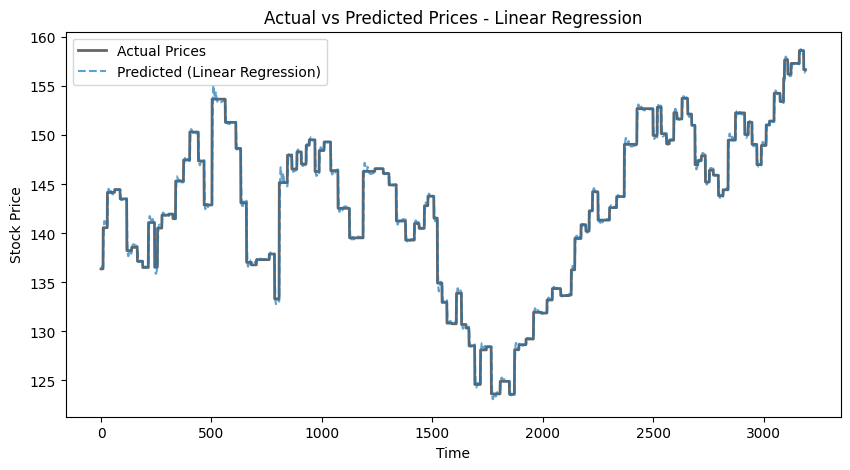

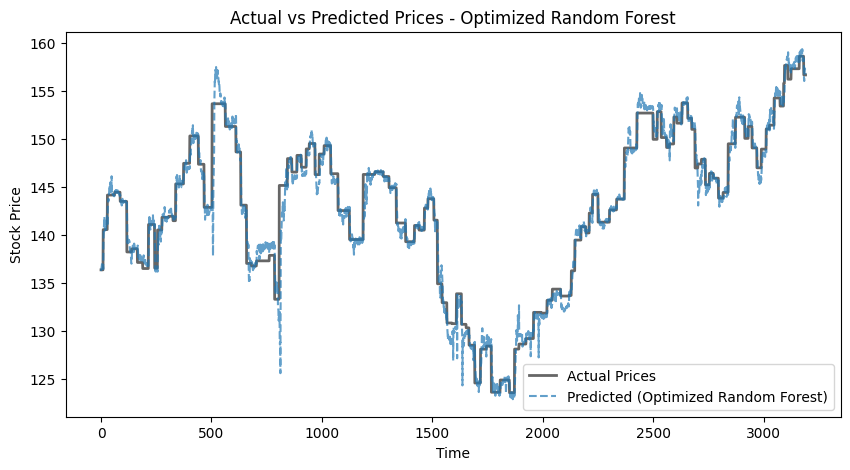

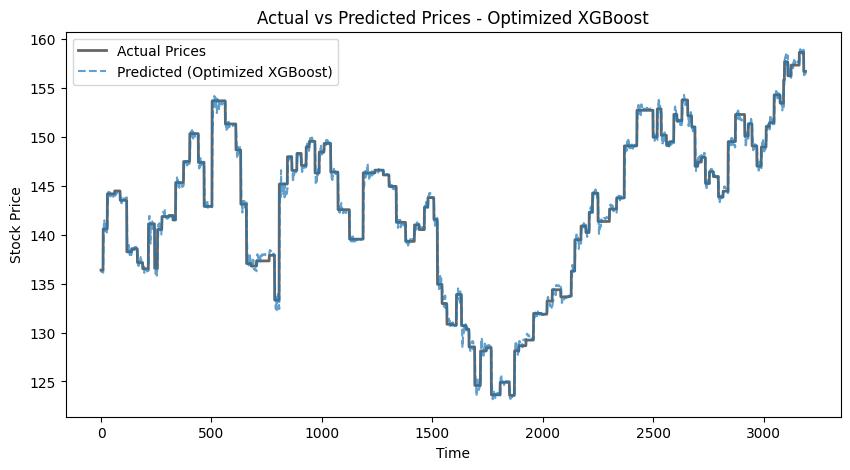

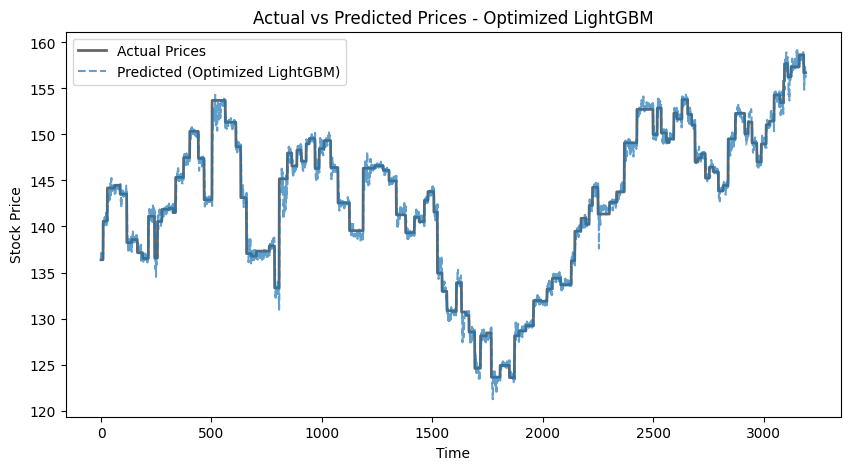

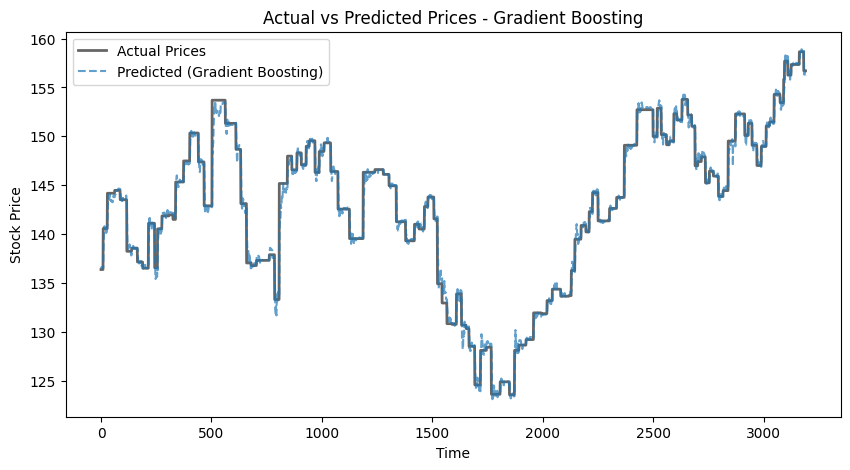

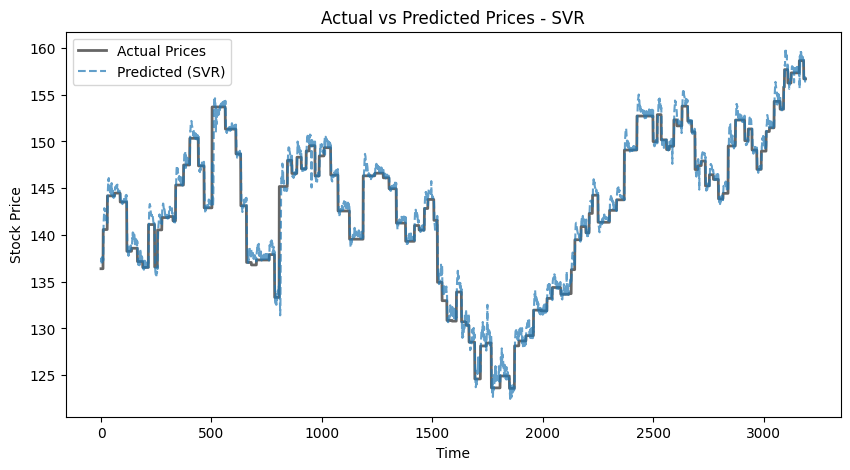

In [18]:
# Plot Actual vs. Predicted Prices for Each Model
for model_name, predictions in model_predictions.items():
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label="Actual Prices", color="black", linewidth=2, alpha=0.6)
    plt.plot(predictions, label=f"Predicted ({model_name})", linestyle="dashed", alpha=0.7)
    plt.title(f"Actual vs Predicted Prices - {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

In [19]:
#  Final Model Performance Comparison
results_df = pd.DataFrame(model_results, index=["RMSE", "R²"]).T
results_df.loc["Improved LSTM"] = [lstm_rmse, lstm_r2]


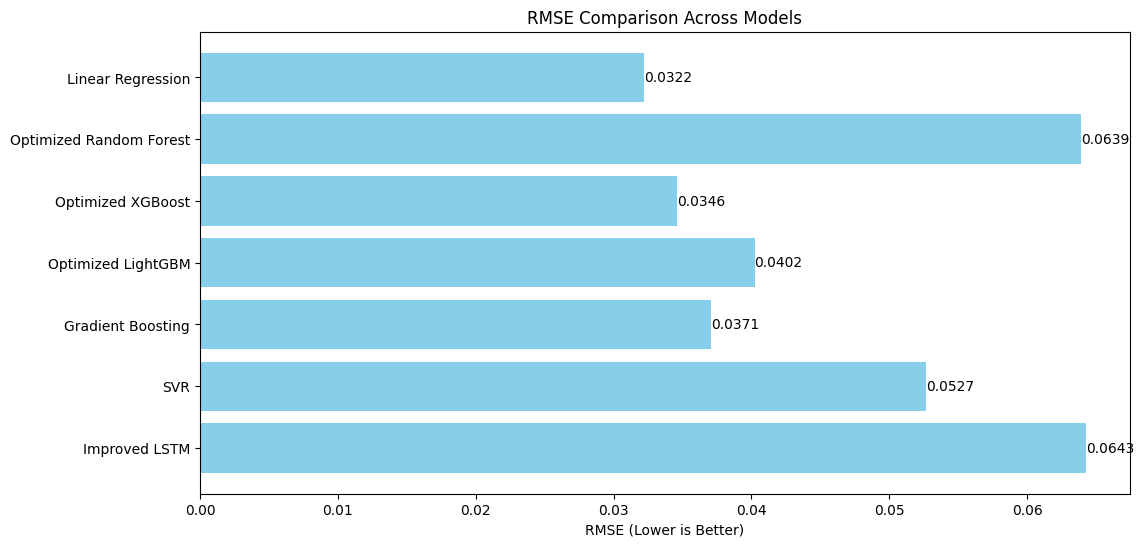

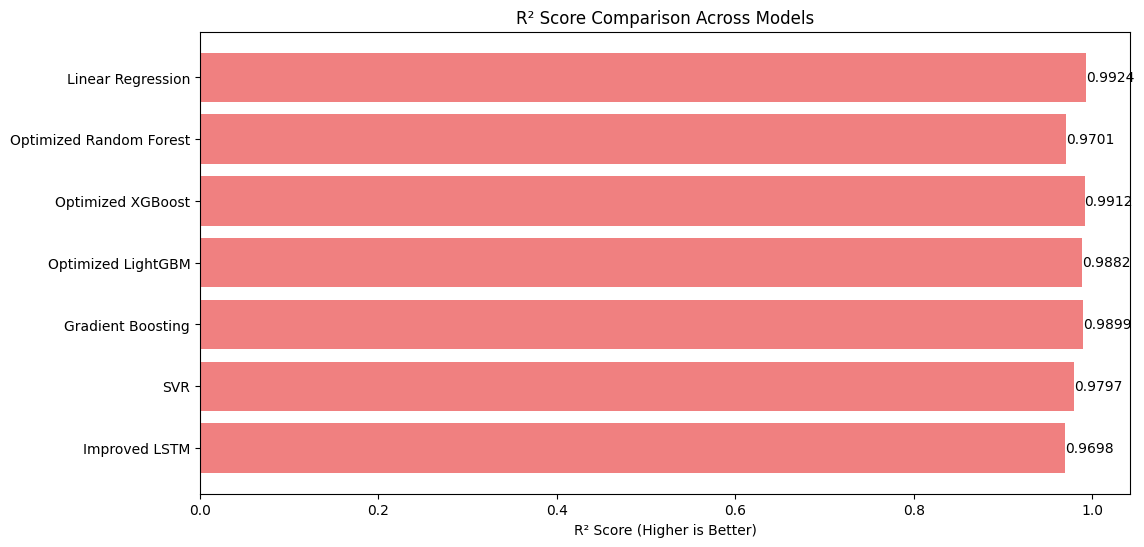

In [20]:
#  Plot RMSE & R² Score Comparison
plt.figure(figsize=(12, 6))
bars = plt.barh(results_df.index, results_df["RMSE"], color='skyblue')
plt.xlabel("RMSE (Lower is Better)")
plt.title("RMSE Comparison Across Models")

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')

plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 6))
bars = plt.barh(results_df.index, results_df["R²"], color='lightcoral')
plt.xlabel("R² Score (Higher is Better)")
plt.title("R² Score Comparison Across Models")

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.4f}', va='center')

plt.gca().invert_yaxis()
plt.show()

/Users/shobians./Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shobians./Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/shobians./Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/shobians./Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

SARIMAX Evaluation:
RMSE: 1.3177
R² Score: 0.8692


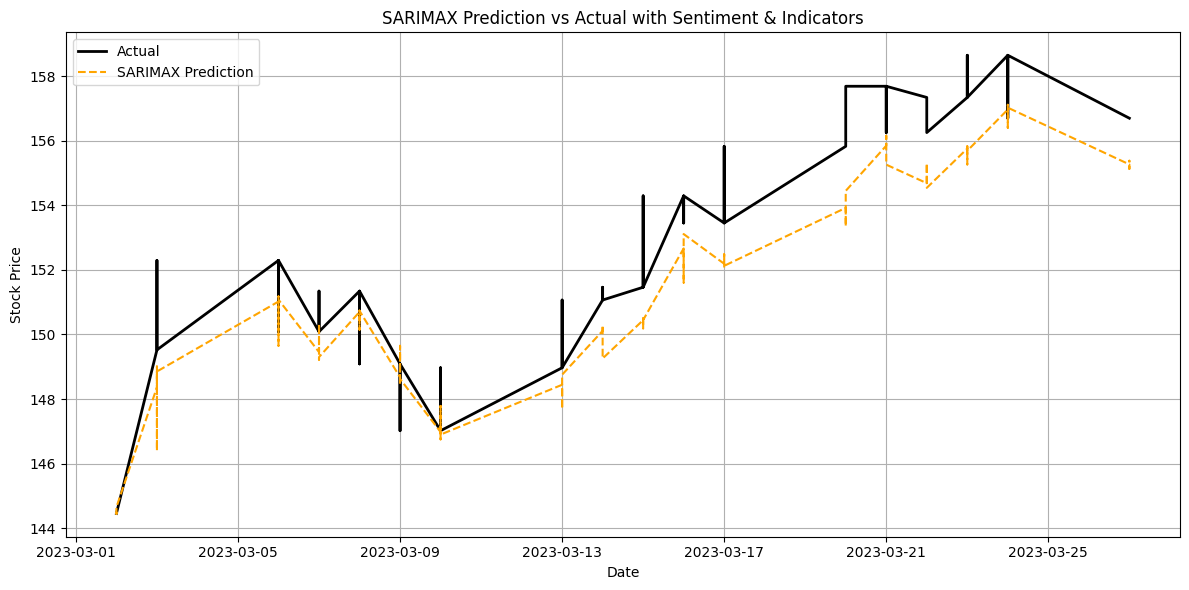

        Date  Actual_Close  SARIMAX_Prediction
0 2023-03-02    144.453247          144.503342
1 2023-03-02    144.453247          144.443339
2 2023-03-02    144.453247          144.611127
3 2023-03-02    144.453247          144.634629
4 2023-03-02    144.453247          144.558348
5 2023-03-02    144.453247          144.645180
6 2023-03-02    144.453247          144.628719
7 2023-03-02    144.453247          144.613181
8 2023-03-02    144.453247          144.590088
9 2023-03-02    144.453247          144.648577


In [41]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare Data
df = df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")
df.dropna(subset=["Close_Price", "Close_next"], inplace=True)

df.set_index("Date", inplace=True)

# Features
regressors = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", 
              "MA20", "sentiment_polarity", "sentiment_neg", 
              "sentiment_neu", "sentiment_pos"]

# Split into Train/Test (last 30 rows as test)
train_size = len(df) - 360
y_train = df["Close_Price"].iloc[:train_size]
X_train = df[regressors].iloc[:train_size]

y_test = df["Close_next"].iloc[train_size:]
X_test = df[regressors].iloc[train_size:]
test_dates = y_test.index  # Save for plotting

# Fit SARIMAX Model
model = SARIMAX(endog=y_train, exog=X_train, order=(3,1,2), enforce_stationarity=False, enforce_invertibility=False)
SARIMAX_results = model.fit(disp=False)

# Forecast next 30 days
forecast = SARIMAX_results.predict(start=train_size, end=len(df)-1, exog=X_test)

# Evaluation
y_true = y_test.values
y_pred = forecast.values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"SARIMAX Evaluation:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true, label="Actual", color="black", linewidth=2)
plt.plot(test_dates, y_pred, label="SARIMAX Prediction", linestyle="--", color="orange")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("SARIMAX Prediction vs Actual with Sentiment & Indicators")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Output Table
result_table = pd.DataFrame({
    "Date": test_dates,
    "Actual_Close": y_true,
    "SARIMAX_Prediction": y_pred
})
print(result_table.head(10))


/Users/shobians./Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
16:09:49 - cmdstanpy - INFO - Chain [1] start processing
16:09:56 - cmdstanpy - INFO - Chain [1] done processing


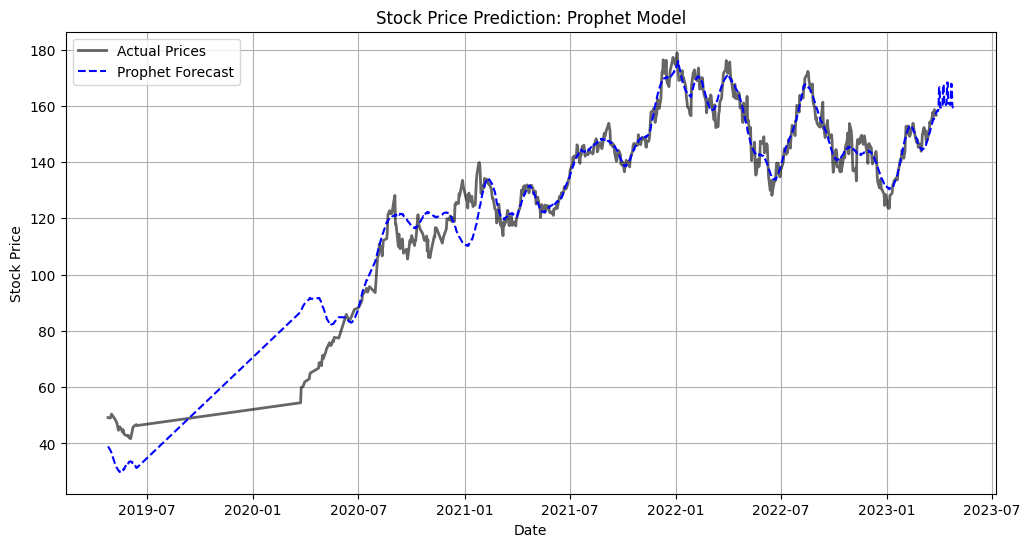

In [ ]:

from prophet import Prophet


# Prepare the dataset for Prophet (Ensure correct column names)
df_prophet = df[["Date", "Close_Price"]].rename(columns={"Date": "ds", "Close_Price": "y"})

# Fit Prophet Model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Create a dataframe for future predictions (30 days ahead)
future = prophet_model.make_future_dataframe(periods=30)  
prophet_forecast = prophet_model.predict(future)

# Plot Prophet Forecast vs Actual Data
plt.figure(figsize=(12, 6))
plt.plot(df_prophet["ds"], df_prophet["y"], label="Actual Prices", color="black", linewidth=2, alpha=0.6)
plt.plot(prophet_forecast["ds"], prophet_forecast["yhat"], label="Prophet Forecast", linestyle="dashed", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction: Prophet Model")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:

scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

lstm_model.save("models/lstm_model.h5")

joblib.dump(models["Optimized LightGBM"], "models/lightgbm.pkl") 
joblib.dump(models["Linear Regression"], "models/linear_regression_model.pkl")
joblib.dump(models["Optimized Random Forest"], "models/random_forest_model.pkl")
joblib.dump(models["Optimized XGBoost"], "models/xgboost_model.pkl")
joblib.dump(models["Gradient Boosting"], "models/gradient_boosting_model.pkl")
joblib.dump(models["SVR"], "models/svr_model.pkl")
joblib.dump(prophet_model, "models/prophet_model.pkl")
joblib.dump(SARIMAX_results, "/Users/shobians./Desktop/FYP/code/My code/final code/models/sarimax_model.pkl")


joblib.dump(scaler_X, "models/scaler_X.pkl")  # Save feature scaler
joblib.dump(scaler_y, "models/scaler_y.pkl")  # Save target

['models/scaler_y.pkl']